Задача: создать и обучить нейросеть, сегментирующую выводы у мк

Требуется закрасить все пространство в черный
Затем уже наложить синим на картинку исходную

Набор: 998 исходников и сегментированных

##Загрузка библиотек для работы с нейросетью

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Activation, concatenate, Conv2DTranspose, Dense
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K

from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import os
import cv2
import random
import time
%matplotlib inline
from PIL import Image

from google.colab import files

In [ ]:
#загрузка гугл-диска с расположением файлов
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


##Обработка изображений с диска

In [ ]:
#путь к диску
directory = '/content/drive/My Drive/Гранит'

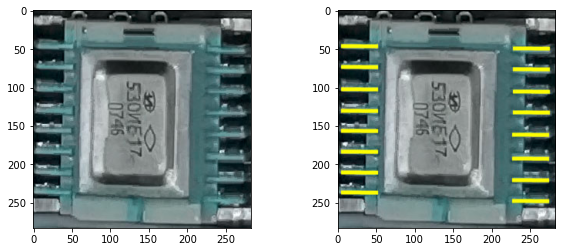

In [ ]:
#размер изображения 283х283
img = cv2.imread(directory+'/Без закрашивания/1.jpg')
mask = cv2.imread(directory+'/С закрашиванием/1.jpg')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].imshow(img)
axes[1].imshow(mask)
plt.show()

Определим значение яркости раскрашенных пикселей и сделаем маску на два класса

In [ ]:
mask = cv2.imread(directory+'/С закрашиванием/1.jpg')
hsv_mask = cv2.cvtColor(mask, cv2.COLOR_RGB2HSV)
light_yellow = (0, 240, 240)
dark_yellow = (255, 255, 255)
segment = cv2.inRange(hsv_mask, light_yellow, dark_yellow)
result = cv2.bitwise_and(mask, mask, mask=segment)

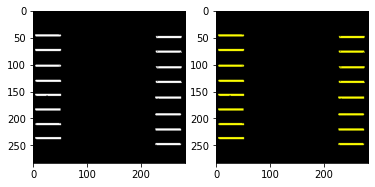

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(segment, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

сделали маску на два класса

##Загрузка изображений с диска

In [ ]:
num_classes = 2 #количество классов на изображении
img_width = 256
img_height = 256

In [ ]:
images_micro = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + '/Без закрашивания')): # Проходим по всем файлам в каталоге по указанному пути     
    images_micro.append(image.load_img(os.path.join(directory + '/Без закрашивания',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загржуена. Время загрузки: ', time.time() - cur_time, 'c', sep='') # Отображаем время загрузки картинок обучающей выборки

Обучающая выборка загржуена. Время загрузки: 453.936714887619c


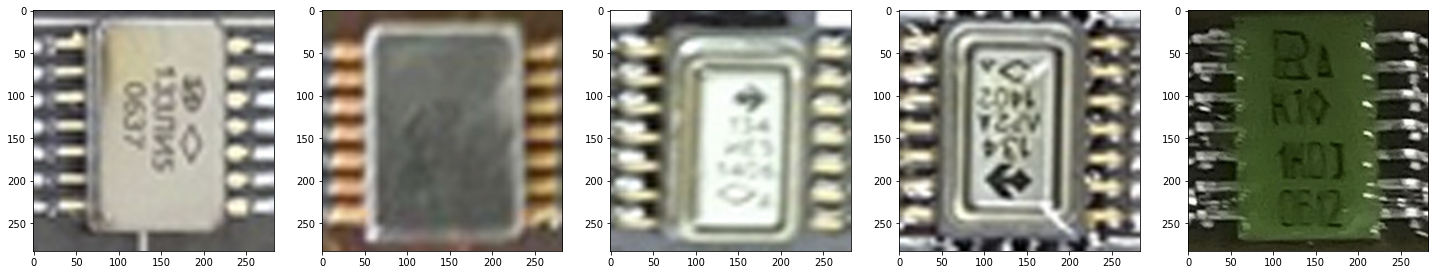

In [ ]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = random.choice(images_micro) # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

In [ ]:
segments_micro = [] # Создаем пустой список для хранений сегментированных изображений обучающей выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + '/С закрашиванием')): # Проходим по всем файлам в каталоге по указанному пути     
    segments_micro.append(image.load_img(os.path.join(directory + '/С закрашиванием',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загржуена. Время загрузки: ', time.time() - cur_time, 'c', sep='') # Отображаем время загрузки картинок обучающей выборки

Обучающая выборка загржуена. Время загрузки: 440.91211104393005c


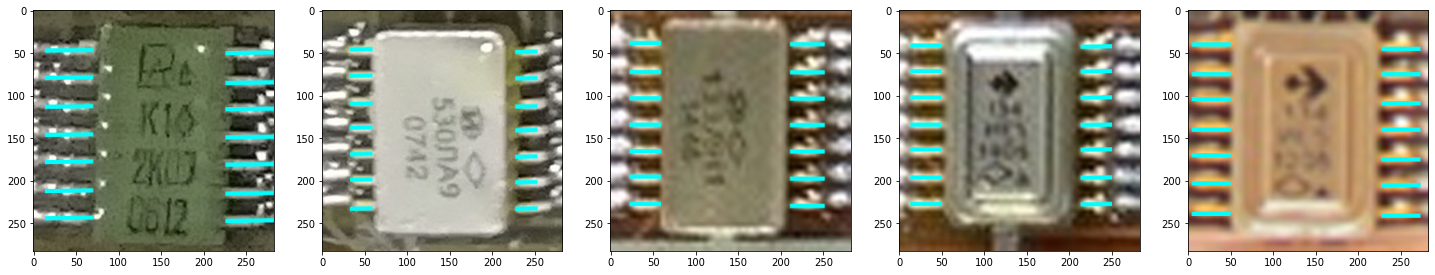

In [ ]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = random.choice(segments_micro) # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

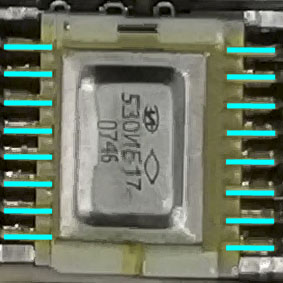

In [ ]:
segments_micro[0]

##Загрузка данных с диска с помощью нампи

In [ ]:
img_micro = []
mask_micro = []

for i in range(375):
    img = cv2.imread('drive/My Drive/Гранит/Без закрашивания/'+str(i+1)+'.jpg')
    mask = cv2.imread('drive/My Drive/Гранит/С закрашиванием/'+str(i+1)+'.jpg')
    img = cv2.resize(img, (256, 256))
    mask = cv2.resize(mask, (256, 256))
    img_micro.append(img)
    mask_micro.append(mask)
for i in range(377,1000):
    img = cv2.imread('drive/My Drive/Гранит/Без закрашивания/'+str(i+1)+'.jpg')
    mask = cv2.imread('drive/My Drive/Гранит/С закрашиванием/'+str(i+1)+'.jpg')
    img = cv2.resize(img, (256, 256))
    mask = cv2.resize(mask, (256, 256))
    img_micro.append(img)
    mask_micro.append(mask)

0


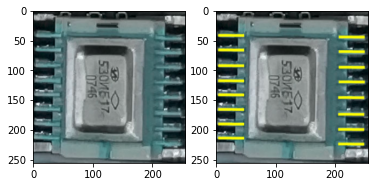

1


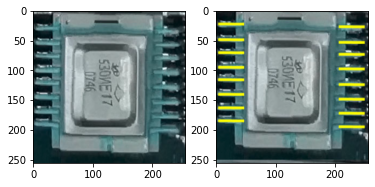

2


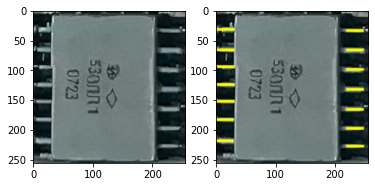

3


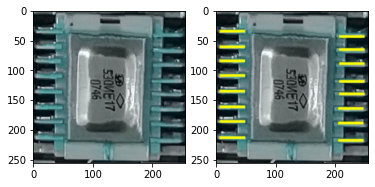

4


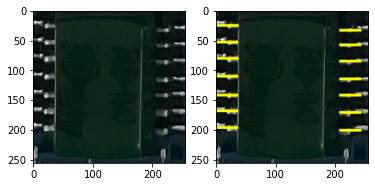

In [ ]:
for i in range(5):
  print(i)
  fig, axes = plt.subplots(nrows=1, ncols=2)
  axes[0].imshow(img_micro[i])
  axes[1].imshow(mask_micro[i])
  plt.show()

In [ ]:
images_micro = np.array(img_micro)
masks_micro = np.array(mask_micro)
print(images_micro.shape)
print(masks_micro.shape)

(998, 256, 256, 3)
(998, 256, 256, 3)


находим маску (из двух классов)

In [ ]:
#значения яркости пикселей находили методом подбора
hsv_mask = cv2.cvtColor(masks_micro[0], cv2.COLOR_RGB2HSV)
light_yellow = (25, 240, 240)
dark_yellow = (40, 255, 255)
segment = cv2.inRange(hsv_mask, light_yellow, dark_yellow)
result = cv2.bitwise_and(masks_micro[0], masks_micro[0], mask=segment)

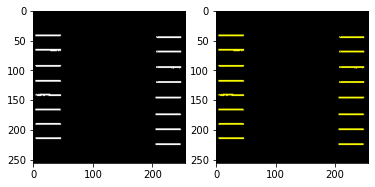

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(segment, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

In [ ]:
segments = []
for i in range(masks_micro.shape[0]):
  hsv_mask = cv2.cvtColor(masks_micro[i], cv2.COLOR_RGB2HSV)
  light_yellow = (25, 240, 240)
  dark_yellow = (40, 255, 255)
  segment = cv2.inRange(hsv_mask, light_yellow, dark_yellow)
  result = cv2.bitwise_and(masks_micro[i], masks_micro[i], mask=segment)
  segments.append(result)

In [ ]:
segment_micro = np.array(segments)
print(segment_micro.shape)

(998, 256, 256, 3)


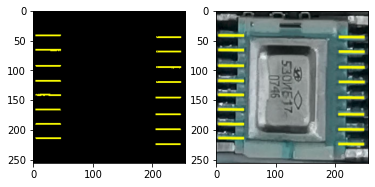

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(segment_micro[0])
plt.subplot(1, 2, 2)
plt.imshow(mask_micro[0])
plt.show()

##Создание выборки

In [ ]:
def color2index(color):
  index=0
  if (color[0] + color[1] + color[2]) > 40 : index = 1 #выводы
  return index

In [ ]:
def index2color(index2):
  index = np.argmax(index2)
  color = []
  if index == 0:
    color = [0, 0, 0] #всё остальное
  elif index == 1:
    color = [40, 255, 255] #выводы
  return color

In [ ]:
# Функция перевода индекса пикслея в to_categorical
def rgbToohe(y, num_classes): 
  y2 = y.copy() # Создаем копию входного массива
  y = y.reshape(y.shape[0] * y.shape[1], 3) # Решейпим в двумерный массив
  yt = [] # Создаем пустой лист
  for i in range(len(y)): # Проходим по всем трем канала изображения
    yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) # Переводим пиксели в индексы и преобразуем в OHE
  yt = np.array(yt) # Преобразуем в numpy
  yt = yt.reshape(y2.shape[0], y2.shape[1], num_classes) # Решейпим к исходныму размеру
  return yt # Возвращаем сформированный массив

In [ ]:
# Функция формирования yTrain
def yt_prep(data, num_classes):
  yTrain = [] # Создаем пустой список под карты сегметации
  for seg in data: # Пробегаем по всем файлам набора с сегминтированными изображениями
    y = image.img_to_array(seg) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    y = rgbToohe(y, num_classes) # Получаем OHE-представление сформированного массива
    yTrain.append(y) # Добавляем очередной элемент в yTrain
    if len(yTrain) % 100 == 0: # Каждые 100 шагов
      print(len(yTrain)) # Выводим количество обработанных изображений
  return np.array(yTrain) # Возвращаем сформированный yTrain

In [ ]:
xTrain = [] # Создаем пустой список под обучающую выборку
for img in images_micro: 
    x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    xTrain.append(x) # Добавляем очередной элемент в xTrain
xTrain = np.array(xTrain) # Переводим в numpy
print(xTrain.shape) # Размерность обучающей выборки

(998, 256, 256, 3)


In [ ]:
cur_time = time.time()
yTrain = yt_prep(segment_micro, num_classes) 
print('Время обработки: ', round(time.time() - cur_time, 2),'c')

100
200
300
400
500
600
700
800
900
Время обработки:  792.28 c


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(xTrain, yTrain, test_size = 0.1)

In [ ]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(898, 256, 256, 3)
(100, 256, 256, 3)
(898, 256, 256, 2)
(100, 256, 256, 2)


In [ ]:
np.save(directory+'/x_train', x_train)
np.save(directory+'/x_val', x_val)
np.save(directory+'/y_train', y_train)
np.save(directory+'/y_val', y_val)

##Загрузка готовых данных с диска

In [ ]:
#путь к диску
directory = '/content/drive/My Drive/Гранит'

In [ ]:
x_train = np.load(directory+'/x_train.npy')
x_val = np.load(directory+'/x_val.npy')
y_train = np.load(directory+'/y_train.npy')
y_val = np.load(directory+'/y_val.npy')

##Обучение модели

In [ ]:
def dice_coef(y_true, y_pred):
  return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [ ]:
img_input = Input((256,256,3))                                       # Создаем входной слой с размерностью input_shape

    # Block 1
x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
x = Activation('relu')(x)                                              # Добавляем слой Activation

x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

x = MaxPooling2D(2)(block_1_out)                                        # Добавляем слой MaxPooling2D

    # Block 2
x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        # Добавляем Conv2D-слой с 128-нейронами
x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
x = Activation('relu')(x)                                              # Добавляем слой Activation

x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)        # Добавляем Conv2D-слой с 128-нейронами
x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

x = MaxPooling2D(2)(block_2_out)                                        # Добавляем слой MaxPooling2D

    # Block 3
x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)        # Добавляем Conv2D-слой с 256-нейронами
x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
x = Activation('relu')(x)                                              # Добавляем слой Activation

x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
x = Activation('relu')(x)                                              # Добавляем слой Activation

x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
block_3_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_3_out

x = MaxPooling2D(2)(block_3_out)                                        # Добавляем слой MaxPooling2D

    # Block 4
x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)        # Добавляем Conv2D-слой с 512-нейронами
x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
x = Activation('relu')(x)                                              # Добавляем слой Activation

x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
x = Activation('relu')(x)                                              # Добавляем слой Activation

x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
block_4_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_4_out
x = block_4_out 

    # UP 2
x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 256 нейронами
x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
x = Activation('relu')(x)                                              # Добавляем слой Activation

x = concatenate([x, block_3_out])                                      # Объединем текущий слой со слоем block_3_out
x = Conv2D(256, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 256 нейронами
x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
x = Activation('relu')(x)                                              # Добавляем слой Activation

x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 3
x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 128 нейронами
x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
x = Activation('relu')(x)                                              # Добавляем слой Activation

x = concatenate([x, block_2_out])                                      # Объединем текущий слой со слоем block_2_out
x = Conv2D(128, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128 нейронами
x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
x = Activation('relu')(x)                                              # Добавляем слой Activation

x = Conv2D(128, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 128 нейронами
x = BatchNormalization()(x) # Добавляем слой BatchNormalization
x = Activation('relu')(x) # Добавляем слой Activation

    # UP 4
x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
x = BatchNormalization()(x) # Добавляем слой BatchNormalization
x = Activation('relu')(x) # Добавляем слой Activation

x = concatenate([x, block_1_out])  # Объединем текущий слой со слоем block_1_out
x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
x = BatchNormalization()(x) # Добавляем слой BatchNormalization
x = Activation('relu')(x) # Добавляем слой Activation

x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
x = BatchNormalization()(x) # Добавляем слой BatchNormalization
x = Activation('relu')(x) # Добавляем слой Activation

x = Conv2D(2, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

model = Model(img_input, x) # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
model.compile(optimizer=Adam(lr=1e-03),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

**Обучение модели**


In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=16, validation_data = (x_val, y_val), verbose=1) # Обучаем модель на выборке по двум классам

Epoch 1/10
57/57 [==============================] - 23s 398ms/step - loss: 0.1015 - dice_coef: 0.9427 - val_loss: 0.3523 - val_dice_coef: 0.9296
Epoch 2/10
57/57 [==============================] - 22s 390ms/step - loss: 0.0545 - dice_coef: 0.9699 - val_loss: 0.1065 - val_dice_coef: 0.9357
Epoch 3/10
57/57 [==============================] - 22s 390ms/step - loss: 0.0511 - dice_coef: 0.9713 - val_loss: 0.0965 - val_dice_coef: 0.9318
Epoch 4/10
57/57 [==============================] - 22s 390ms/step - loss: 0.0477 - dice_coef: 0.9724 - val_loss: 0.0532 - val_dice_coef: 0.9677
Epoch 5/10
57/57 [==============================] - 22s 390ms/step - loss: 0.0459 - dice_coef: 0.9733 - val_loss: 0.0557 - val_dice_coef: 0.9724
Epoch 6/10
57/57 [==============================] - 22s 390ms/step - loss: 0.0440 - dice_coef: 0.9741 - val_loss: 0.0516 - val_dice_coef: 0.9755
Epoch 7/10
57/57 [==============================] - 22s 390ms/step - loss: 0.0428 - dice_coef: 0.9745 - val_loss: 0.0508 - val_dic

**Сохранение весов модели**

In [ ]:
model.save_weights(directory+'/model_micro.h5')

**Загрузка весов предобученной модели**

In [ ]:
model.load_weights(directory+'/model_micro.h5')

In [ ]:
predL = model.predict(x_train)            # Делаем предсказание по xTrain
print(predL.shape)

(898, 256, 256, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


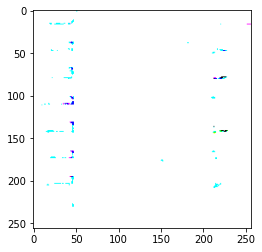

In [ ]:
n = 9
plt.imshow(x_train[n])
plt.show()

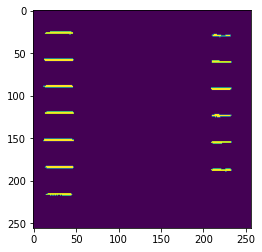

In [ ]:
img = 255*np.uint8(np.round(predL[n]))[:,:,-1]
plt.imshow(img)
plt.show()

In [ ]:
num_classes = 2 #количество классов на изображении
img_width = 256
img_height = 256

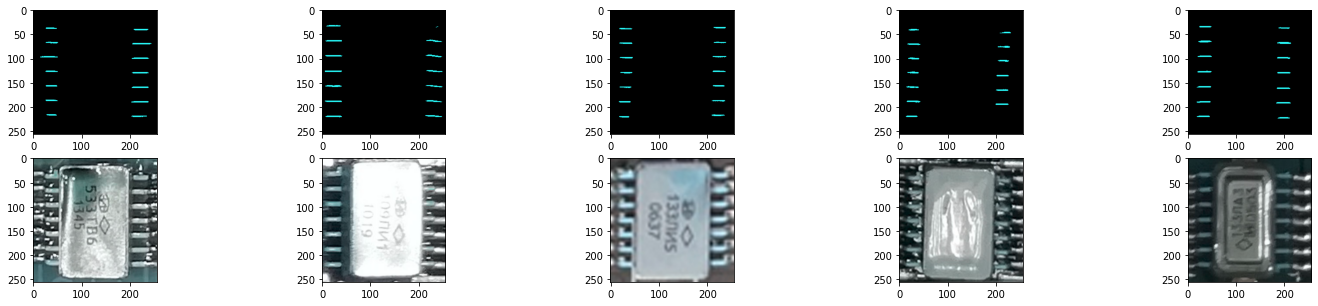

In [ ]:
count = 5
n_classes = 2
indexes = np.random.randint(0, len(x_val), count) # Получаем count случайных индексов
fig, axs = plt.subplots(2, count, figsize=(25, 5)) #Создаем полотно из n графиков
for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
  predict = np.array(model.predict(x_val[idx].reshape(1, img_width, img_height, 3))) # Предиктим картику
  pr = predict[0] # Берем нулевой элемент из перидкта
  pr1 = [] # Пустой лист под сегментированную картинку из predicta
  pr = pr.reshape(-1, n_classes) # Решейпим предикт
  for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
    pr1.append(index2color(pr[k])) # Переводим индекс в писксель
  pr1 = np.array(pr1) # Преобразуем в numpy
  pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
  img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
  axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
  axs[1,i].imshow(Image.fromarray(x_val[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение        
plt.show() 

##Результат - наложение маски на МК

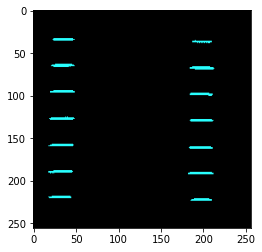

In [ ]:
seg = Image.fromarray(pr1.astype('uint8')).convert('RGBA')
plt.imshow(seg)

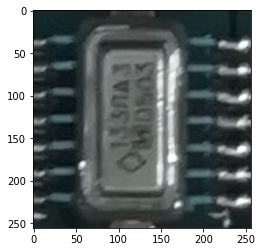

In [ ]:
plt.imshow(Image.fromarray(x_val[idx].astype('uint8')))

In [ ]:
mask = np.array(seg)
mask[mask[:,:,0] <= 10] = [0, 0, 0, 0]
mask[mask[:,:,0] > 10] = [0, 200, 0, 200]

Итог

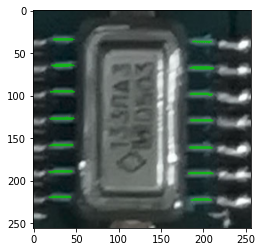

In [ ]:
img2 = Image.fromarray(x_val[idx].astype('uint8'))
img = Image.fromarray(mask).convert('RGBA')
img2.paste(img, (0, 0),img)
plt.imshow(img2)

зеленые выводы на изображении